In [1]:
import matplotlib.pyplot as plt
import vtk
from vtk.util.numpy_support import vtk_to_numpy
import xarray as xr
import numpy as np
import scipy.stats
import xarray_symTensor2d.xarray_symTensor2d as sT
import matplotlib.cm as cm
import lib_cti.lib_cti_uvec_meshio as lcum

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": "Helvetica",
    "font.size": 18
})

# CraFT vs Rheolef
## CraFT

In [2]:
def load_tensor_vtk(adr,tensor):
    suffix=['11.vtk','22.vtk','33.vtk','12.vtk','13.vtk','23.vtk']
    sT=[]
    for ss in suffix:
        reader = vtk.vtkDataSetReader()
        reader.SetFileName(adr+tensor+ss)
        reader.Update()
        ug  = reader.GetOutput()
        sT.append(vtk_to_numpy(ug.GetPointData().GetScalars()).reshape((ug.GetDimensions()[::-1])))

    return xr.DataArray(np.stack(sT,axis=-1),dims=['x','y','z','sT'])

In [3]:
adr='../simulation_hexa/3D_with_grain/CraFT-EVP/output/n500_121_t=04.00000000e+04_'

In [4]:
strain=load_tensor_vtk(adr,'strain')
stress=load_tensor_vtk(adr,'stress')
strain_eq=strain.sT.eqVonMises(var='strain')
stress_eq=stress.sT.eqVonMises(var='stress')

In [5]:
kde_Dc=[]
kde_Sc=[]
for i in range(6):
    kde_Dc.append(scipy.stats.gaussian_kde(np.array(strain[...,i]).flatten()))
    kde_Sc.append(scipy.stats.gaussian_kde(np.array(stress[...,i]).flatten()))

kde_Deqc=scipy.stats.gaussian_kde(np.array(strain_eq[...,i]).flatten())
kde_Seqc=scipy.stats.gaussian_kde(np.array(stress_eq[...,i]).flatten())

In [6]:
stress.coords['time']=1
res=stress.sT.eigh()

In [7]:
res

<xarray.Dataset> Size: 19MB
Dimensions:  (x: 51, y: 102, z: 51, uvecs: 2)
Coordinates:
    time     int64 8B 1
  * x        (x) int64 408B 0 1 2 3 4 5 6 7 8 9 ... 42 43 44 45 46 47 48 49 50
  * y        (y) int64 816B 0 1 2 3 4 5 6 7 8 9 ... 93 94 95 96 97 98 99 100 101
Dimensions without coordinates: z, uvecs
Data variables:
    a1       (x, y, z) float64 2MB 1.281 1.329 1.067 ... 1.602 1.296 1.682
    a2       (x, y, z) float64 2MB -0.06895 -0.3305 -0.67 ... 0.9026 1.256 0.834
    a3       (x, y, z) float64 2MB -0.8786 -1.342 -1.264 ... -0.2857 -0.01609
    e1       (x, y, z, uvecs) float64 4MB 0.03594 1.678 ... -0.445 0.9429
    e2       (x, y, z, uvecs) float64 4MB -1.385 0.6266 1.553 ... 0.4931 0.8872
    e3       (x, y, z, uvecs) float64 4MB 1.531 0.9564 1.516 ... 1.566 1.04

(<Axes: >, <matplotlib.tri._tricontour.TriContourSet at 0x758420e17cd0>)

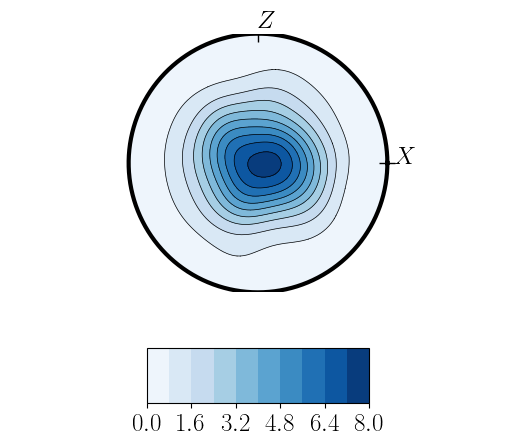

In [8]:
res.e3.uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,cmap=cm.Blues,plot_cm=True,xoz_plane=True)

## rheolef with grain

In [9]:
folder='../simulation_hexa/3D_with_grain/r3ice/'

tensor_P1=xr.Dataset()
tensor_P1['D']=lcum.load_tensor_P1(folder,'D')
tensor_P1['S']=lcum.load_tensor_P1(folder,'sigma')
tensor_P1['Deq']=tensor_P1['D'].sT.eqVonMises(var='strain')
tensor_P1['Seq']=tensor_P1['S'].sT.eqVonMises(var='stress')

In [10]:
at_d=strain[...,1].mean()/np.mean(tensor_P1.D[1,...,1])
at_s=stress[...,1].mean()/np.mean(tensor_P1.S[1,...,1])

In [11]:
strain[...,1].mean()

<xarray.DataArray ()> Size: 8B
array(-0.00887893)

In [12]:
print(at_d)

<xarray.DataArray ()> Size: 8B
array(68.32151663)


In [13]:
tensor_P1['D']=tensor_P1['D']*at_d
tensor_P1['Deq']=tensor_P1['Deq']*at_d
#tensor_P1['S']=tensor_P1['S']*at_s

In [14]:
kde_Dr=[]
kde_Sr=[]
for i in range(6):
    kde_Dr.append(scipy.stats.gaussian_kde(np.array(tensor_P1.D[1,...,i]).flatten()))
    kde_Sr.append(scipy.stats.gaussian_kde(np.array(tensor_P1.S[1,...,i]).flatten()))

kde_Deqr=scipy.stats.gaussian_kde(np.array(tensor_P1['Deq'][1,...]).flatten())
kde_Seqr=scipy.stats.gaussian_kde(np.array(tensor_P1['Seq'][1,...]).flatten())

In [15]:
Sg=tensor_P1['S'][1,...]
Sg.coords['time']=1
eig_rh_g=Sg.sT.eigh()

(<Axes: >, <matplotlib.tri._tricontour.TriContourSet at 0x758420c5f0d0>)

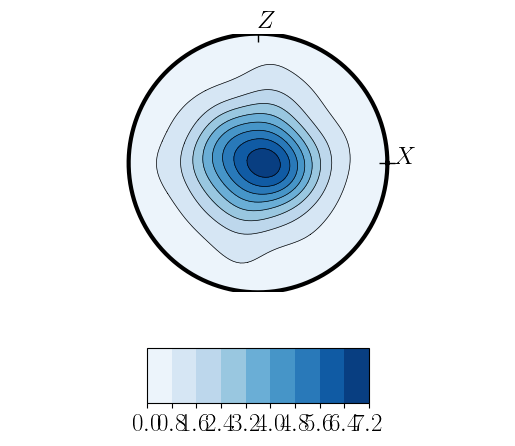

In [16]:
eig_rh_g.e3.uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,cmap=cm.Blues,plot_cm=True,xoz_plane=True)

## Rheolef without grain

In [17]:
folder='../simulation_hexa/Calibration/polycrystal/'


tensor_P1_nG=xr.Dataset()
tensor_P1_nG['D']=lcum.load_tensor_P1(folder,'D')
tensor_P1_nG['S']=lcum.load_tensor_P1(folder,'sigma')
tensor_P1_nG['Deq']=tensor_P1_nG['D'].sT.eqVonMises(var='strain')
tensor_P1_nG['Seq']=tensor_P1_nG['S'].sT.eqVonMises(var='stress')

In [18]:
at_d_nG=strain[...,1].mean()/np.mean(tensor_P1_nG.D[1,...,1])
tensor_P1_nG['D']=tensor_P1_nG['D']*at_d_nG
tensor_P1_nG['Deq']=tensor_P1_nG['Deq']*at_d_nG


In [19]:
kde_Dr_nG=[]
kde_Sr_nG=[]
for i in range(6):
    kde_Dr_nG.append(scipy.stats.gaussian_kde(np.array(tensor_P1_nG.D[1,...,i]).flatten()))
    kde_Sr_nG.append(scipy.stats.gaussian_kde(np.array(tensor_P1_nG.S[1,...,i]).flatten()))

kde_Deqr_nG=scipy.stats.gaussian_kde(np.array(tensor_P1_nG['Deq'][1,...]).flatten())
kde_Seqr_nG=scipy.stats.gaussian_kde(np.array(tensor_P1_nG['Seq'][1,...]).flatten())

In [20]:
tensor_P1_nG

<xarray.Dataset> Size: 756kB
Dimensions:  (time: 2, y: 1, x: 3375, sT: 6)
Dimensions without coordinates: time, y, x, sT
Data variables:
    D        (time, y, x, sT) float64 324kB 0.0 0.0 0.0 ... 0.1509 -0.01386
    S        (time, y, x, sT) float64 324kB 0.0 0.0 0.0 ... 0.3753 -0.4808 1.102
    Deq      (time, y, x) float64 54kB 0.0 0.0 0.0 0.0 ... 0.1803 0.1766 0.3605
    Seq      (time, y, x) float64 54kB 0.0 0.0 0.0 0.0 ... 6.388 12.1 3.183

In [21]:
S_ng=tensor_P1_nG['S'][1,...]
S_ng.coords['time']=1
eig_rh_ng=S_ng.sT.eigh()

(<Axes: >, <matplotlib.tri._tricontour.TriContourSet at 0x758420b48f40>)

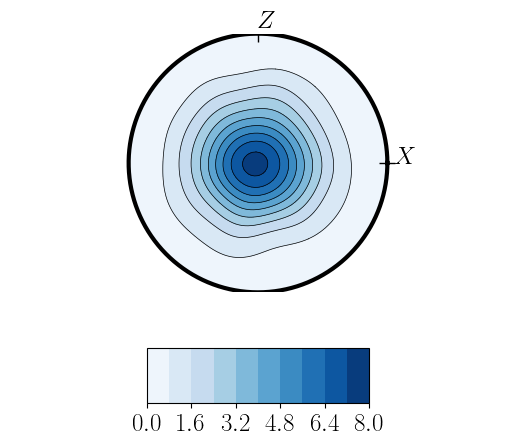

In [22]:
eig_rh_ng.e3.uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,cmap=cm.Blues,plot_cm=True,xoz_plane=True)

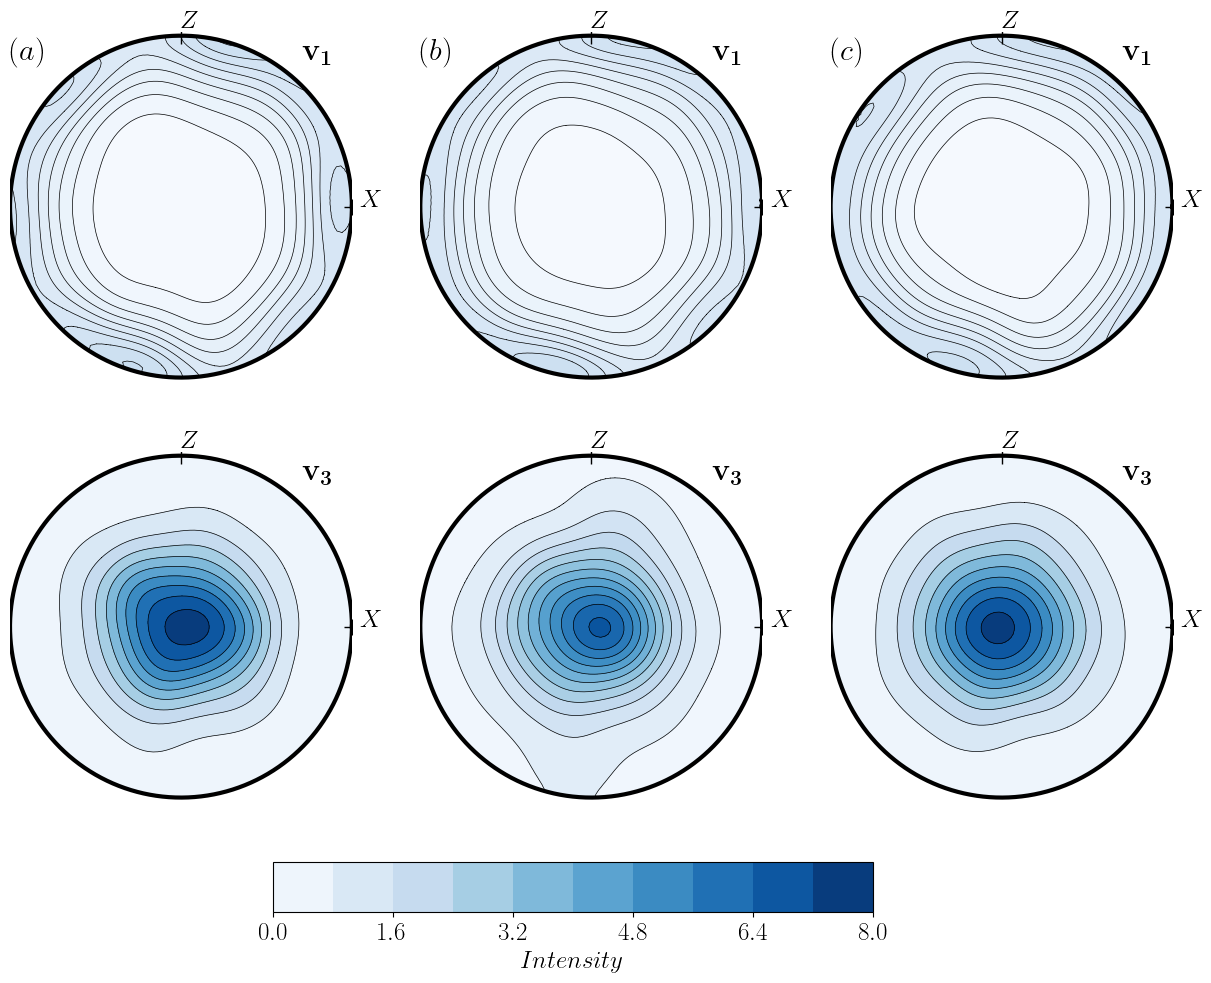

In [23]:
xx=1
fig=plt.figure(figsize=(15,10))
plt.subplot(231)
res.e1.uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,vmax=8,cmap=cm.Blues,plot_cm=False,xoz_plane=True)
plt.annotate("$(a)$",(-2**.5,2**.5-0.2), fontsize=22)
plt.annotate("$\mathbf{v_1}$",(xx**.5,2**.5-0.2), fontsize=22)

plt.subplot(232)
eig_rh_g.e1.uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,vmax=8,cmap=cm.Blues,plot_cm=False,xoz_plane=True)
plt.annotate("$(b)$",(-2**.5,2**.5-0.2), fontsize=22)
plt.annotate("$\mathbf{v_1}$",(xx**.5,2**.5-0.2), fontsize=22)

plt.subplot(233)
eig_rh_ng.e1.uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,vmax=8,cmap=cm.Blues,plot_cm=False,xoz_plane=True)
plt.annotate("$(c)$",(-2**.5,2**.5-0.2), fontsize=22)
plt.annotate("$\mathbf{v_1}$",(xx**.5,2**.5-0.2), fontsize=22)

plt.subplot(234)
res.e3.uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,vmax=8,cmap=cm.Blues,plot_cm=False,xoz_plane=True)
plt.annotate("$\mathbf{v_3}$",(xx**.5,2**.5-0.2), fontsize=22)


plt.subplot(235)
eig_rh_g.e3.uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,vmax=8,cmap=cm.Blues,plot_cm=False,xoz_plane=True)
plt.annotate("$\mathbf{v_3}$",(xx**.5,2**.5-0.2), fontsize=22)

plt.subplot(236)
_,ff_cbar=eig_rh_ng.e3.uvecs.plotODF(plotOT=False,angle=np.array([0]),vmin=0,vmax=8,cmap=cm.Blues,plot_cm=False,xoz_plane=True)
plt.annotate("$\mathbf{v_3}$",(xx**.5,2**.5-0.2), fontsize=22)

cax = fig.add_axes([0.3, 0, 0.4, 0.05])
cbar = plt.colorbar(ff_cbar, cax=cax, orientation='horizontal')
cbar.set_label('$Intensity$')

## Figures

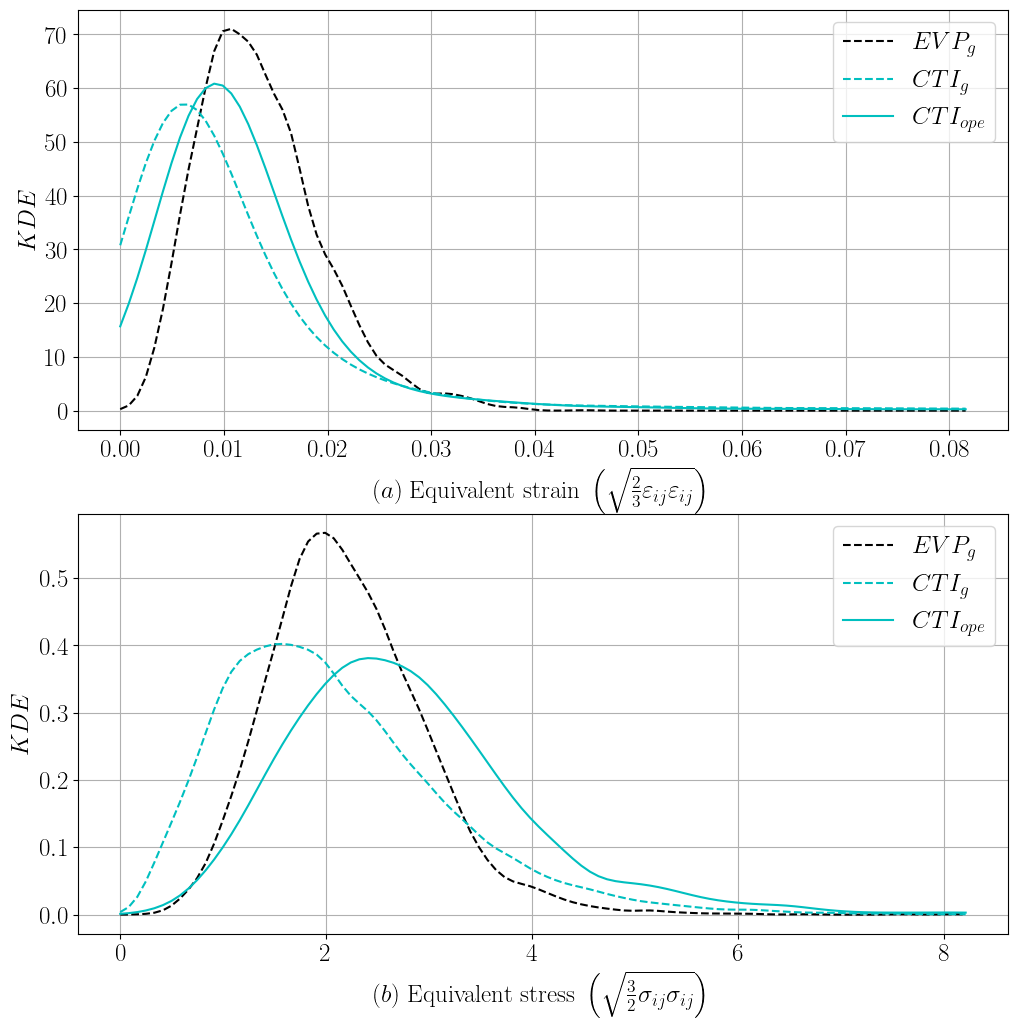

In [24]:
plt.figure(figsize=(12,12))
plt.subplot(211)

xm=strain_eq.max()
x_kde=np.linspace(0,xm,100)

plt.plot(x_kde,kde_Deqc(x_kde).T,'--k',label='$EVP_g$')
plt.plot(x_kde,kde_Deqr(x_kde).T,'--c',label='$CTI_g$')
plt.plot(x_kde,kde_Deqr_nG(x_kde).T,'-c',label='$CTI_{ope}$')
plt.grid()
plt.xlabel(r'$(a)~\textrm{Equivalent strain}~\left(\sqrt{\frac{2}{3}\varepsilon_{ij}\varepsilon_{ij}}\right)$')
plt.ylabel(r'$KDE$')
plt.legend()


plt.subplot(212)
xm=stress_eq.max()
x_kde=np.linspace(0,xm,100)

plt.plot(x_kde,kde_Seqc(x_kde).T,'--k',label='$EVP_g$')
plt.plot(x_kde,kde_Seqr(x_kde).T,'--c',label='$CTI_g$')
plt.plot(x_kde,kde_Seqr_nG(x_kde).T,'-c',label='$CTI_{ope}$')
plt.grid()
plt.xlabel(r'$(b)~\textrm{Equivalent stress}~\left(\sqrt{\frac{3}{2}\sigma_{ij}\sigma_{ij}}\right)$')
plt.ylabel(r'$KDE$')
plt.legend()


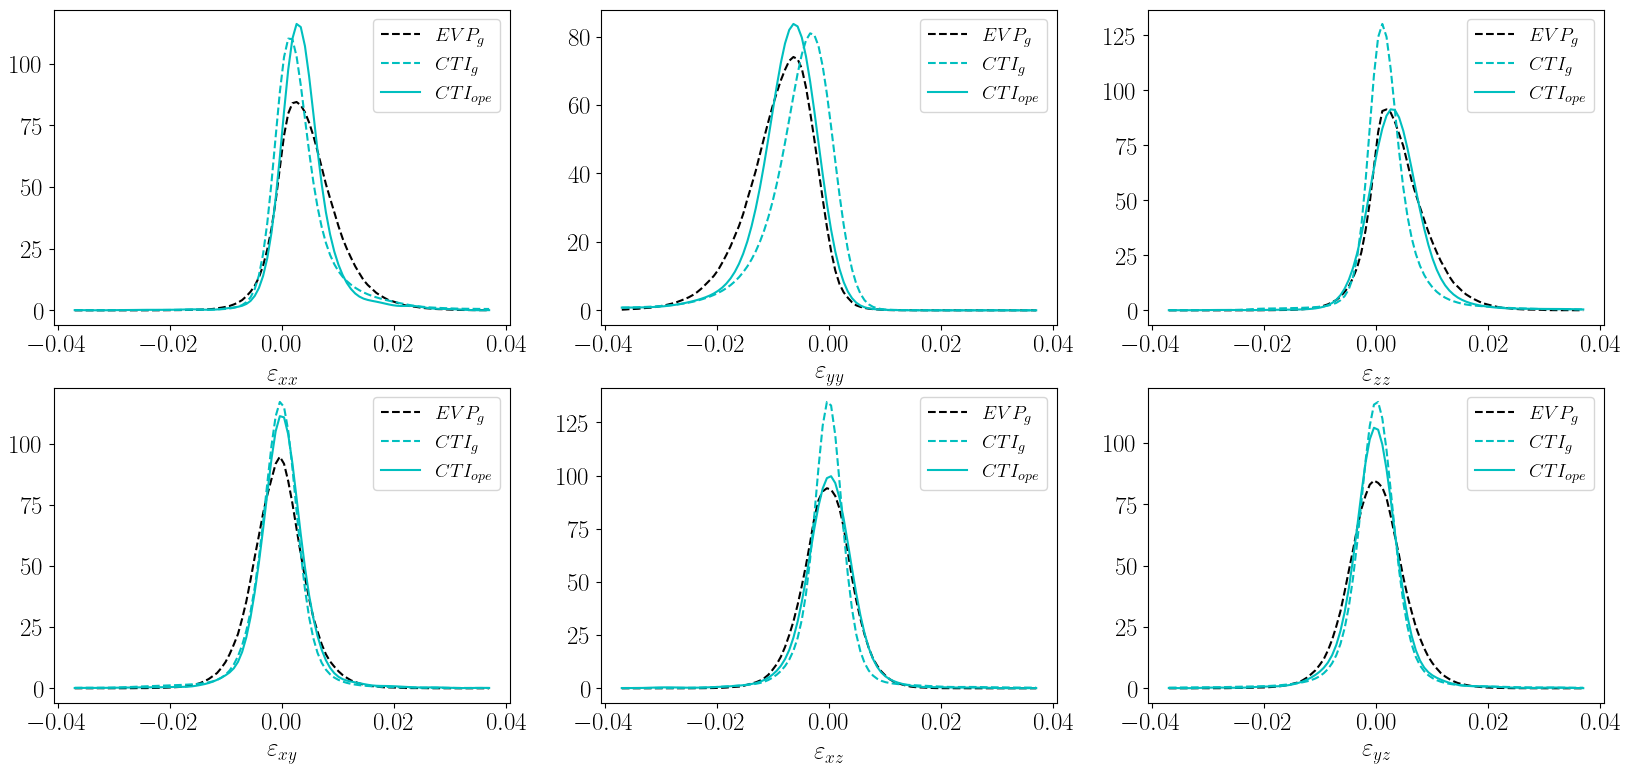

In [25]:
xm=np.abs(strain).max()*0.5
x_kde=np.linspace(-xm,xm,100)

plt.figure(figsize=(20,9))
ll=[r'$\varepsilon_{xx}$',r'$\varepsilon_{yy}$',r'$\varepsilon_{zz}$',r'$\varepsilon_{xy}$',r'$\varepsilon_{xz}$',r'$\varepsilon_{yz}$']
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(x_kde,kde_Dc[i](x_kde).T,'--k',label='$EVP_g$')
    plt.plot(x_kde,kde_Dr[i](x_kde).T,'--c',label='$CTI_g$')
    plt.plot(x_kde,kde_Dr_nG[i](x_kde).T,'-c',label='$CTI_{ope}$')
    plt.xlabel(ll[i])
    plt.legend(prop={'size': 14})

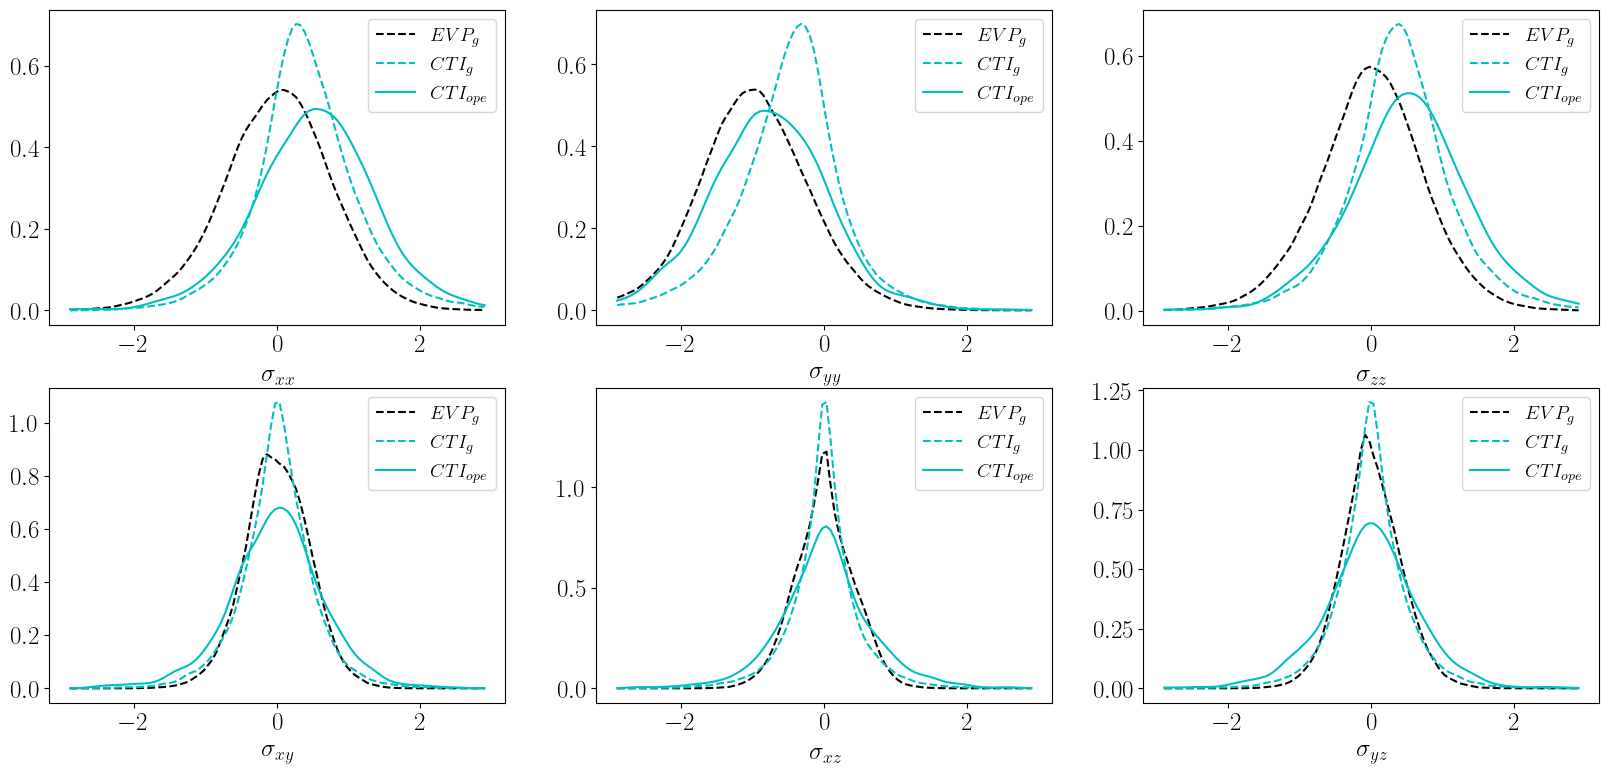

In [26]:
xm=np.abs(stress).max()*0.5
x_kde=np.linspace(-xm,xm,100)

plt.figure(figsize=(20,9))
ll=[r'$\sigma_{xx}$',r'$\sigma_{yy}$',r'$\sigma_{zz}$',r'$\sigma_{xy}$',r'$\sigma_{xz}$',r'$\sigma_{yz}$']
for i in range(6):
    plt.subplot(2,3,i+1)
    plt.plot(x_kde,kde_Sc[i](x_kde).T,'--k',label='$EVP_g$')
    plt.plot(x_kde,kde_Sr[i](x_kde).T,'--c',label='$CTI_g$')
    plt.plot(x_kde,kde_Sr_nG[i](x_kde).T,'-c',label='$CTI_{ope}$')
    plt.xlabel(ll[i])
    plt.legend(prop={'size': 14})